In [1]:
from data import load_data, data_prep
from train import train, objective, build_hidden_mults
from data_openml import DataSetCatCon
from torch.utils.data import DataLoader
from models import SAINT
import torch.optim as optim
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostRegressor
import pandas as pd
import optuna
import torch

X1, y = load_data(200, 500)

# select best fingerprints 
fgpts = X1.iloc[:, 2:-1]
model2 = CatBoostRegressor()  # FIXME
model2.fit(fgpts, y)
fgpts_selector = SelectFromModel(model2, prefit=True, threshold="mean", max_features=100)
X = pd.concat([X1.iloc[:, :2], X1.loc[:, fgpts.columns[fgpts_selector.get_support()]]], axis=1)

cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std, continuous_mean_std = data_prep(X, y, datasplit=[.65, .15, .2])

train_ds = DataSetCatCon(X_train, y_train, cat_idxs,'reg',continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=256, shuffle=True,num_workers=4)

valid_ds = DataSetCatCon(X_valid, y_valid, cat_idxs,'reg', continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=256, shuffle=False,num_workers=4)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs,'reg', continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=256, shuffle=False,num_workers=4)

/home/carlotapuente/anaconda3/envs/saint_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Learning rate set to 0.036696
0:	learn: 15.1511250	total: 71.4ms	remaining: 1m 11s
1:	learn: 14.9213571	total: 78.5ms	remaining: 39.1s
2:	learn: 14.7038124	total: 85.4ms	remaining: 28.4s
3:	learn: 14.5101825	total: 90.5ms	remaining: 22.5s
4:	learn: 14.3420660	total: 95ms	remaining: 18.9s
5:	learn: 14.1604607	total: 98.8ms	remaining: 16.4s
6:	learn: 13.9723608	total: 103ms	remaining: 14.6s
7:	learn: 13.8060814	total: 110ms	remaining: 13.7s
8:	learn: 13.6586120	total: 113ms	remaining: 12.4s
9:	learn: 13.5019291	total: 115ms	remaining: 11.4s
10:	learn: 13.3371383	total: 119ms	remaining: 10.7s
11:	learn: 13.2145623	total: 124ms	remaining: 10.2s
12:	learn: 13.0614705	total: 128ms	remaining: 9.72s
13:	learn: 12.9232904	total: 131ms	remaining: 9.21s
14:	learn: 12.7986853	total: 133ms	remaining: 8.75s
15:	learn: 12.6642619	total: 137ms	remaining: 8.42s
16:	learn: 12.5336869	total: 140ms	remaining: 8.07s
17:	learn: 12.4395012	total: 144ms	remaining: 7.83s
18:	learn: 12.3346276	total: 146ms	rema

In [2]:
# select best hyperparameters
# study_name = "saint"  # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)

study1 = optuna.create_study()
study1.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, testloader, first_trial=True), n_trials=2) # FIXME
optim_params1 = study1.best_params 

lr = optim_params1['lr']
wd = optim_params1['weight_decay']
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=10, reduction_factor=3
    ),
)
study.optimize(lambda trial: objective(trial, cat_dims, con_idxs, trainloader, validloader, testloader, lr=lr, wd=wd), n_trials=2) # FIXME
optim_params = study.best_params 

[I 2024-06-19 01:47:51,242] A new study created in memory with name: no-name-8822d398-ed29-4645-a933-877c1d273ea4
[I 2024-06-19 01:48:16,043] Trial 0 finished with value: 200.30686111450194 and parameters: {'lr': 3.35247000683858e-05, 'weight_decay': 0.0009686101525614581}. Best is trial 0 with value: 200.30686111450194.
[I 2024-06-19 01:48:43,535] Trial 1 finished with value: 74.41976070404053 and parameters: {'lr': 0.0004942536579103452, 'weight_decay': 0.0002870541604254361}. Best is trial 1 with value: 74.41976070404053.
[I 2024-06-19 01:48:43,540] A new study created in memory with name: no-name-6dd19581-6500-4989-9a37-ff1647a9a8c1
[I 2024-06-19 01:49:55,357] Trial 0 finished with value: 66.26714015007019 and parameters: {'dim': 59, 'depth': 1, 'heads': 7, 'attn_dropout': 0.2758421536003729, 'ff_dropout': 0.7074589714447705, 'mlp_hidden_mults': 4, 'final_mlp_style': 'sep', 'optimizer': 'Adam', 'scheduler': 'linear'}. Best is trial 0 with value: 66.26714015007019.
[I 2024-06-19 01:

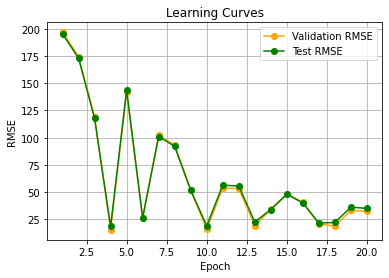

In [3]:
optim_params['mlp_hidden_mults'] = build_hidden_mults(optim_params['mlp_hidden_mults'])  # TODO: importar funcion

model = SAINT(
    categories = tuple(cat_dims), 
    num_continuous = len(con_idxs),                
    dim = optim_params['dim'],                         
    dim_out = 1,                       
    depth = optim_params['depth'],                        
    heads = optim_params['heads'],                         
    attn_dropout = optim_params['attn_dropout'],             
    ff_dropout = optim_params['ff_dropout'],                  
    mlp_hidden_mults = optim_params['mlp_hidden_mults'],       
    cont_embeddings = 'MLP',
    attentiontype = 'colrow',
    final_mlp_style = optim_params['final_mlp_style'],
    y_dim = 1 # porque es regression 
)

epochs = 10

if optim_params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=optim_params1['lr'], momentum=0.9, weight_decay=optim_params1['weight_decay'])
elif optim_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=optim_params1['lr'])
elif optim_params['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(model.parameters(),lr=optim_params1['lr'])

if optim_params['scheduler'] == 'cosine':
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
elif optim_params['scheduler'] == 'linear':
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[epochs // 2.667, epochs // 1.6, epochs // 1.142], gamma=0.1)

valid_rmse = train(model, optimizer, scheduler, epochs, trainloader, validloader, testloader, plot=True)


- load_data de toda la db
- epochs (en objective y main)
- n_trials en study.optimize